# Intent Classification Model on Atis Data
I plan to build a series of models. 
1. Embedding plus LSTM Model
2. Attention based model for trying deep architecture
3. Evaluation and serving of the model
   
Let's start

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import random
import re

set up the device and pytorch seed for reproducibility

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    torch.manual_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

Using device: mps


## Data Preprocessing

The dataset contains 5,047 sentences belonging to 26 intents (it is ATIS from Kaggle). The sentences are queries from the ATIS (Airline Travel Information System) domain, and the intents are things like "atis_flight", "atis_airfare", "atis_ground_service", etc. The dataset is split into a training set and a test set.

In this section, I will tokenize the text and build a vocabulary. I will also encode the labels as numerical values. This will help build an intent classifier model that can be used for chatbots in any domain and language
1. Tokenize and Build Vocabulary
2. Get the Indexed and Padded Sequences as Tensors

3. Encode Labels
Also handle unknown labels, print a list of classes in the data

### Text to Index Lists
The text_to_indices function takes a string of text and the word_to_index dictionary. I use list comprehensions to apply this function to all entries in the training and testing datasets. I pad them and then use for training a PyTorch model.


In [3]:
from utils import tokenize, build_vocabulary, text_to_indices, encode_labels, convert_and_pad_sequences

# Load the training data
train = pd.read_csv("data/atis/train.tsv",sep='\t', header=None)
train.columns = ["text", "label"]
test= pd.read_csv("data/atis/test.tsv",sep='\t', header=None)
test.columns = ["text", "label"]

#build vocabulary
vocab_size=1000
word_to_index = build_vocabulary(train["text"], vocab_size)
print(f"Vocabulary Size: {len(word_to_index)}")

#get the indexed and padded sequences as tensors
train_indices = [text_to_indices(text, word_to_index) for text in train["text"]]
test_indices = [text_to_indices(text, word_to_index) for text in test["text"]]
train_padded=convert_and_pad_sequences(train_indices,device)
test_padded=convert_and_pad_sequences(test_indices,device)
# Now, train_padded and test_padded are the padded sequence tensors
print("Padded Training Sequences:", train_padded.size())
print("Padded Testing Sequences:", test_padded.size())

# Convert labels to numerical values
le = encode_labels(train,test)
train_labels = le.transform(train["label"])
test_labels = le.transform(test["label"])
print("Label Encoding:", dict(zip(le.classes_, le.transform(le.classes_))))

Vocabulary Size: 890
Padded Training Sequences: torch.Size([4634, 46])
Padded Testing Sequences: torch.Size([850, 30])
Label Encoding: {'abbreviation': 0, 'aircraft': 1, 'aircraft+flight+flight_no': 2, 'airfare': 3, 'airfare+flight_time': 4, 'airline': 5, 'airline+flight_no': 6, 'airport': 7, 'capacity': 8, 'cheapest': 9, 'city': 10, 'distance': 11, 'flight': 12, 'flight+airfare': 13, 'flight_no': 14, 'flight_time': 15, 'ground_fare': 16, 'ground_service': 17, 'ground_service+ground_fare': 18, 'meal': 19, 'quantity': 20, 'restriction': 21, '<unknown>': 22}


## Data Loader

In [4]:
from torch.utils.data import TensorDataset, DataLoader
# Create TensorDatasets
# TensorDataset combines a dataset and a label, and provides an iterable over the given dataset. The arguments should be tensors of the same size in the 0th dimension. Any other dimension will be considered as the sample dimension and will be iterated along. This dataset is especially useful to wrap tensors that represent input and target or that are already in batches, e.g. for mini-batch SGD.
train_data = TensorDataset(train_padded.to(device), torch.tensor(train_labels).to(device))
test_data = TensorDataset(test_padded.to(device), torch.tensor(test_labels).to(device))

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
print("Number of training batches:", len(train_loader))
print("Number of test batches:", len(test_loader))

Number of training batches: 145
Number of test batches: 27


### Closer look at class distribtuion

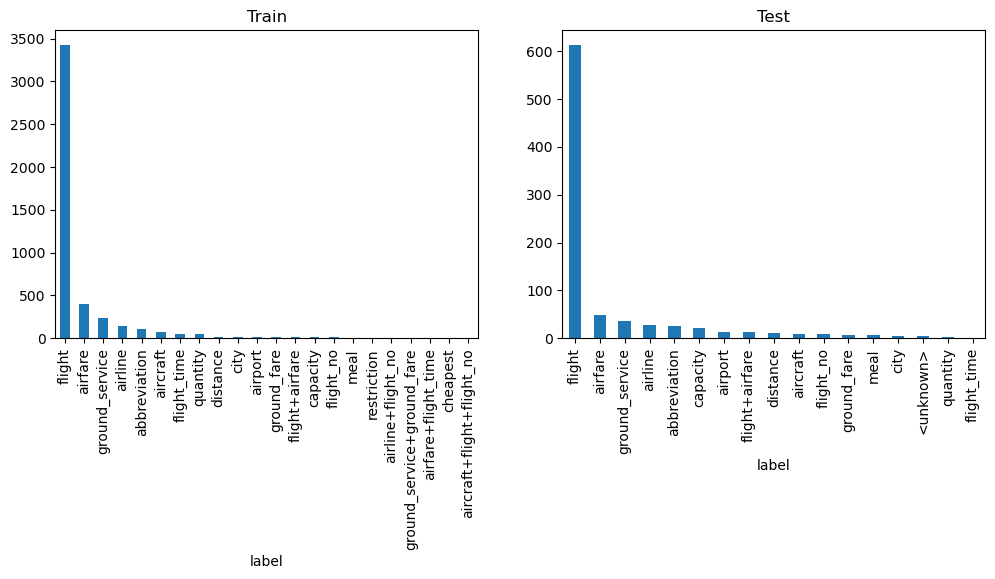

In [5]:
import matplotlib.pyplot as plt
# Plot the class distribution ins test and train
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
train.label.value_counts().plot(kind='bar', ax=ax1)
ax1.set_title("Train")
test.label.value_counts().plot(kind='bar', ax=ax2)
ax2.set_title("Test")
plt.show()

## Vectorized Data

Atis data is now vectorized. This is the first step for getting to an NLP model. We can start playing with models now. The first step is to build an embedding model. 

# Simple NLP Model through Embeddings and LSTM
Embeddings in combination with Recurrent Networkds e.g. LSTM are basic soup for many NLP models due to sequence nature of language tasks. Typically the Embedding dimensions are 50-300 and LSTM dimensions are 100 to 500

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow
import mlflow.pytorch

class IntentClassifierLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(IntentClassifierLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)  # Batch normalization layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Embedding layer
        embedded = self.embedding(x)

        # Dropout layer
        dropped = self.dropout1(embedded)

        # LSTM layer
        lstm_out, (hidden, _) = self.lstm(dropped)
        # Take the output of the last time step
        hidden = hidden[-1]
        # Batch normalization
        normalized = self.batch_norm(hidden)

        # Fully connected layer
        out = self.fc(normalized)
        return out

# Instantiate the model with dropout and batch normalization

Great!. my first model is here , if I want to use advance embeddings, I can also use pretrained embeddings, including contextualized embeddings from the task. Lets refine the
Embedding Model by adding an Attention Layer. Attention Layer has an O(n2logn) complexity in terms of hidden dimensions of LSTM. It takes every combination of hidden dimensiton and finds their correlation through dot products in a matrix multiplication. This is why it is very good at focusing on different parts of input and finding their relationships.

In [7]:
import torch.nn.functional as F

class SelfAttentionLayer(nn.Module):
    def __init__(self, feature_size):
        super(SelfAttentionLayer, self).__init__()
        self.feature_size = feature_size

        # Linear transformations for Q, K, V from the same source
        self.key = nn.Linear(feature_size, feature_size)
        self.query = nn.Linear(feature_size, feature_size)
        self.value = nn.Linear(feature_size, feature_size)

    def forward(self, x, mask=None):
        # Apply linear transformations
        keys = self.key(x)
        queries = self.query(x)
        values = self.value(x)

        # Scaled dot-product attention
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.feature_size, dtype=torch.float32))

        # Apply mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax
        attention_weights = F.softmax(scores, dim=-1)

        # Multiply weights with values
        output = torch.matmul(attention_weights, values)

        return output
class IntentClassifierLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(IntentClassifierLSTMWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.attention = SelfAttentionLayer(hidden_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        dropped = self.dropout(embedded)
        lstm_out, _ = self.lstm(dropped)

        # Apply attention
        attn_out = self.attention(lstm_out)
        final_output= attn_out[:, -1, :]
        normalized = self.batch_norm(final_output)

        out = self.fc(normalized)
        return out

### Set up the hyper parameters
vocab_size is the number of unique words in your vocabulary.
embedding_dim is the number of dimensions for each word embedding.
IntentClassifierLSTM is a basic PyTorch model class with an embedding layer and LSTM.
The forward method defines how data passes through the model. 
The input is a tensor of token indices, like the output of your padding step.
This setup will initialize the embeddings randomly, and they will be updated during training. If you have pre-trained embeddings that you want to use, you can initialize the nn.Embedding layer with these pre-trained weights. 

In [8]:
# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
learning_rate=0.001
weight_decay=1e-4
dropout_rate=0.4
embedding_dim =64            # Size of each embedding vector
hidden_dim = 128               # Number of features in the hidden state of the LSTM
batch_size = 32
output_dim = len(le.classes_)  # Number of classes
num_epochs=10
# Create a string that summarizes these parameters
params_str = f"Vocab Size: {vocab_size}\n" \
             f"Embedding Dim: {embedding_dim}\n" \
             f"Hidden Dim: {hidden_dim}\n" \
             f"Output Dim: {output_dim}\n" \
             f"Dropout Rate: {dropout_rate}\n" \
             f"learning Rate: {learning_rate}\n" \
             f"epochs: {num_epochs}"
print(params_str)

Vocab Size: 1000
Embedding Dim: 64
Hidden Dim: 128
Output Dim: 23
Dropout Rate: 0.4
learning Rate: 0.001
epochs: 10


## Training and Evaluation
I Implement a training loop for the model. One can use any optimizer and loss function of your choice. You can also use any other metric that you think is suitable for the comparison.

In [9]:
# Define loss function and optimizer
from torch.optim.lr_scheduler import StepLR

#model = IntentClassifierLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate).to(device)
model = IntentClassifierLSTMWithAttention(vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
for epoch in range(num_epochs):
    train_loss = 0.0
    correct=0.0
    acc=0
    for batch in train_loader:
        # get data
        x, y = batch
        # zero the gradients
        optimizer.zero_grad()
        # forward pass
        y_hat = model(x)
        # compute loss
        loss = loss_function(y_hat, y)
        train_loss += loss.item()

        # backward pass
        loss.backward()
        # step
        optimizer.step()
        # update train loss
        # compute accuracy
        _, predicted = torch.max(y_hat, 1)
        correct += (predicted == y).sum().item()
    # compute average losses
    train_loss /= len(train_loader)
    acc=(correct/len(train_padded))

    # log average losses
    # Log training loss per epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {acc:.4f}')

Epoch [1/10], Loss: 1.5505
Epoch [1/10], Accuracy: 0.7020
Epoch [2/10], Loss: 0.5696
Epoch [2/10], Accuracy: 0.8798
Epoch [3/10], Loss: 0.3819
Epoch [3/10], Accuracy: 0.9143
Epoch [4/10], Loss: 0.2833
Epoch [4/10], Accuracy: 0.9268
Epoch [5/10], Loss: 0.2139
Epoch [5/10], Accuracy: 0.9463
Epoch [6/10], Loss: 0.1929
Epoch [6/10], Accuracy: 0.9502
Epoch [7/10], Loss: 0.1472
Epoch [7/10], Accuracy: 0.9599
Epoch [8/10], Loss: 0.1376
Epoch [8/10], Accuracy: 0.9640
Epoch [9/10], Loss: 0.1215
Epoch [9/10], Accuracy: 0.9685
Epoch [10/10], Loss: 0.1043
Epoch [10/10], Accuracy: 0.9700


### Evaluate the results on the test data set

In [10]:
model.eval()

# evaluate on test set
test_loss = 0.0
correct=0
acc=0
for batch in test_loader:
    # get data
    x, y = batch
    # forward pass
    y_hat = model(x)
    # compute loss
    loss = loss_function(y_hat, y)
    # update test loss
    test_loss += loss.item()
    _, predicted = torch.max(y_hat, 1)
    correct += (predicted == y).sum().item()
# compute average losses
test_loss /= len(test_loader)
acc=(correct/len(test_padded))

# Log the precision and recall

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")


Test Loss: 0.2934
Test Accuracy: 0.9494


### Save the model using pytorch save function

In [11]:
torch.save(model, 'models/E-LSTMAmodel.pth')

### Lets' check the model serving

In [12]:
model_serve = torch.load('models/E-LSTMAmodel.pth')

def predict(model, query, max_length):
    model.eval()
    # Tokenize and prepare input
    query_indices = [text_to_indices(text, word_to_index) for text in query]
    print(query_indices)
    query_tensor = [torch.tensor(seq).to(device) for seq in query_indices]
    print(query_tensor)
    input = pad_sequence(query_tensor, batch_first=True, padding_value=0)
    print(input)
    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(input)
        _, predicted = torch.max(outputs, 1)

    # Convert prediction to label
    return le.inverse_transform(predicted.data.cpu().numpy())
torch.save(model.state_dict(), 'model_state_dict.pth')



query=list()
query.append("what airlines off from love field between 6 and 10 am on june sixth")
query.append("I want to book a fligt")
prediction = predict(model_serve, query,46)
print(f"Predicted label: {prediction}")


[[6, 28, 791, 2, 247, 248, 31, 148, 17, 151, 86, 5, 150, 295], [0, 69, 1, 186, 14, 0]]
[tensor([  6,  28, 791,   2, 247, 248,  31, 148,  17, 151,  86,   5, 150, 295],
       device='mps:0'), tensor([  0,  69,   1, 186,  14,   0], device='mps:0')]
tensor([[  6,  28, 791,   2, 247, 248,  31, 148,  17, 151,  86,   5, 150, 295],
        [  0,  69,   1, 186,  14,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='mps:0')
Predicted label: ['airline' 'flight']
